In [1]:
# AB_Test
# created by John Broberg, on 2022-06-03
# ref. https://towardsdatascience.com/ab-testing-with-python-e5964dd66143
# ref. https://github.com/renatofillinich/ab_test_guide_in_python

#cd Desktop/AB_Test
# git pull https://github.com/JohnBroberg/AB_Test.git

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import statsmodels.stats.api as sms
from math import ceil

%matplotlib inline

data = 'ab_data.csv'
df = pd.read_csv(data)

df

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


In [2]:
df.describe()

,user_id,converted
count,294478.000000,294478.000000
mean,787974.124733,0.119659
std,91210.823776,0.324563
min,630000.000000,0.000000
25%,709032.250000,0.000000
50%,787933.500000,0.000000
75%,866911.750000,0.000000
max,945999.000000,1.000000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [4]:
df.isnull().any()

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

<function matplotlib.pyplot.show(close=None, block=None)>

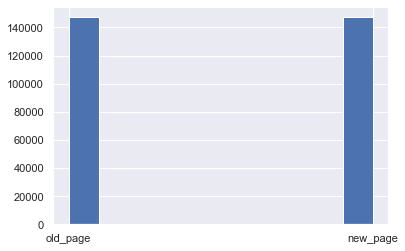

In [5]:
sns.set()

plt.hist(df['landing_page'])
plt.show

In [8]:
pd.crosstab(df['group'], df['landing_page'])

#some group.control landed on new_page, some group.treatment landed on old_page; potential duplicates

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [12]:
#count repeat sessions

session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f'There are {multi_users} users that appear multiple times in the dataset')

There are 3894 users that appear multiple times in the dataset


In [23]:
#remove repeat sessions

users_to_drop = session_counts[session_counts > 1].index

df = df[~df['user_id'].isin(users_to_drop)]

print(f'The udpated dataset now has {df.shape[0]} entries')

The udpated dataset now has 286690 entries


In [6]:
# p_0 = conversion rate of old design (landing_page.old_page)
# p = conversion rate of new design (landing_page.new_page)

# landing_page.converted == 0 = user did not buy the product during this user session
# landing_page.converted == 1 = user did buy the product during this user session


In [7]:

#https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportion_effectsize.html?highlight=proportion_effectsize#statsmodels.stats.proportion.proportion_effectsize
effect_size = sms.proportion_effectsize(0.13, 0.15) #based on expected rates 13% and 15%

# 80% chance to detect actual difference in conversion rates, with statistical significance
power = 0.8

# alpha = 0.05  , confidence level: 95%
alpha = 0.05

#sample size needed
# https://www.statsmodels.org/stable/generated/statsmodels.stats.power.NormalIndPower.solve_power.html#statsmodels.stats.power.NormalIndPower.solve_power
required_n = sms.NormalIndPower().solve_power(
    effect_size
    , nobs1=None  #set to None, to be solved for
    , power=power
    , alpha=alpha
    , ratio=1)

required_n = ceil(required_n)
print(f"Sample size needed for each group: {required_n}")

Sample size needed for each group: 4720


In [25]:
#Sampling

control_sample = df[df['group']=='control'].sample(n=required_n, random_state=22)
treatment_sample = df[df['group']=='treatment'].sample(n=required_n, random_state=22)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)

ab_test

,user_id,timestamp,group,landing_page,converted
0,763854,2017-01-21 03:43:17.188315,control,old_page,0
1,690555,2017-01-18 06:38:13.079449,control,old_page,0
2,861520,2017-01-06 21:13:40.044766,control,old_page,0
3,630778,2017-01-05 16:42:36.995204,control,old_page,0
4,656634,2017-01-04 15:31:21.676130,control,old_page,0
...,...,...,...,...,...
9435,908512,2017-01-14 22:02:29.922674,treatment,new_page,0
9436,873211,2017-01-05 00:57:16.167151,treatment,new_page,0
9437,631276,2017-01-20 18:56:58.167809,treatment,new_page,0
9438,662301,2017-01-03 08:10:57.768806,treatment,new_page,0


In [26]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       9440 non-null   int64 
 1   timestamp     9440 non-null   object
 2   group         9440 non-null   object
 3   landing_page  9440 non-null   object
 4   converted     9440 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 368.9+ KB


In [27]:
ab_test['group'].value_counts()

control      4720
treatment    4720
Name: group, dtype: int64